In [1]:
%matplotlib inline

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt

# Note: there's a lot of code in this script that won't be there when you're done, e.g. code that sets up the dataset and loads a pretrained model

# Paste code that defines model architecture
## This is the first attempt model that you trained on rice

In [3]:
class cifar(nn.Module):
    def __init__(self):
        super(cifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(40, 40, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(40, 20, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(20, 20, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.max_pool2d( F.relu(self.conv2(self.conv1(x))), 2)
        x = F.max_pool2d( F.relu(self.conv4(self.conv3(x))), 2)
        x = F.max_pool2d( F.relu(self.conv6(self.conv5(x))), 2)

        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


# Load cifar class pretrained model
## You trained this model on rice

In [7]:
my_model = cifar()

path_to_pretrained = 'cifar_model_first_attempt'
t = torch.load(path_to_pretrained)
my_model.load_state_dict(t['state_dict'])

# Get CIFAR dataset

In [10]:
cifar_train = torchvision.datasets.CIFAR10('./',
                                           train=True,
                                           transform=transforms.ToTensor())

cifar_test = torchvision.datasets.CIFAR10('./',
                                          train=False,
                                          transform=transforms.ToTensor())

trainset_loader = DataLoader(cifar_train, batch_size=50, shuffle=True, num_workers=1)
testset_loader = DataLoader(cifar_test, batch_size=50, shuffle=True, num_workers=1)


In [116]:
test_batch = iter(trainset_loader).next()
test_images = test_batch[0]
test_labels = test_batch[1]

In [31]:
test_images[0].unsqueeze(0).size()


torch.Size([1, 3, 32, 32])

pred: 4
Label: 4


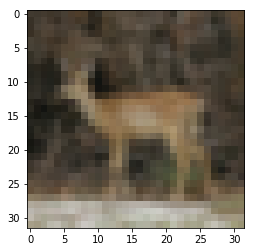



pred: 4
Label: 4


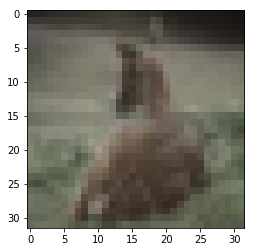



pred: 7
Label: 7


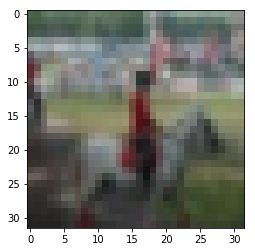



pred: 4
Label: 7


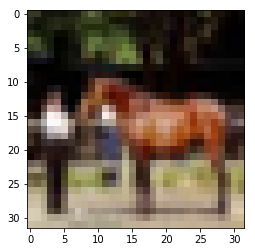



pred: 5
Label: 5


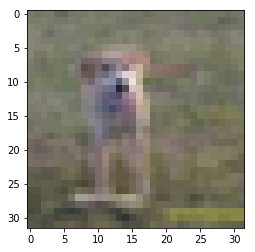



pred: 7
Label: 7


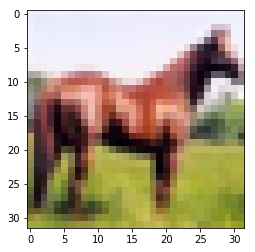



pred: 5
Label: 2


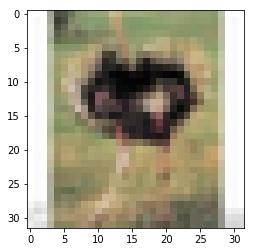



pred: 6
Label: 6


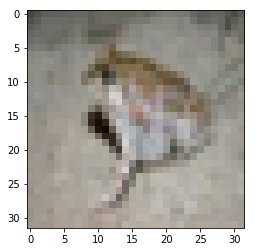



pred: 1
Label: 1


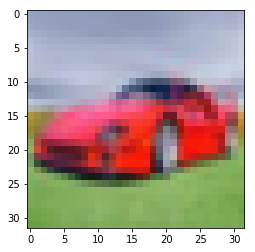



pred: 2
Label: 0


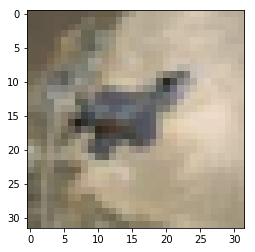



pred: 0
Label: 2


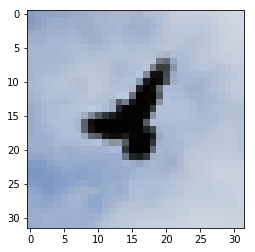



pred: 9
Label: 1


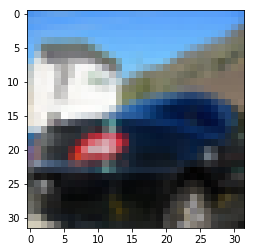



pred: 4
Label: 4


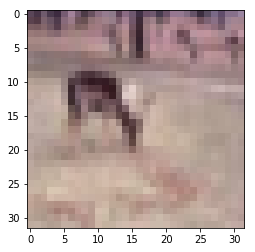



pred: 3
Label: 3


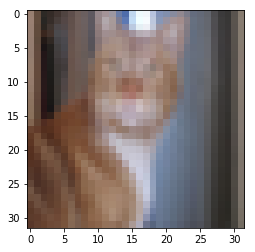



pred: 4
Label: 4


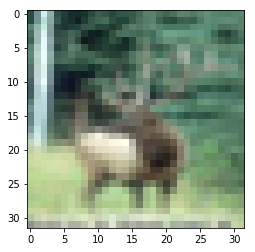



pred: 2
Label: 2


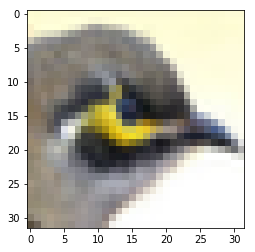



pred: 2
Label: 2


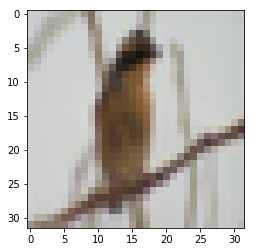



pred: 7
Label: 7


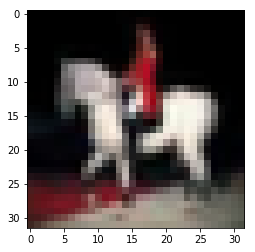



pred: 5
Label: 3


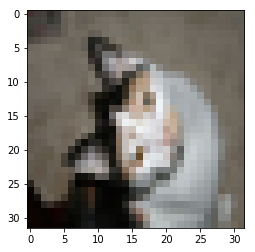



pred: 1
Label: 1


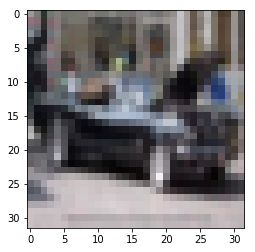

In [117]:
# print out some images to make sure everything is ok
for i in range(20):
    pred = torch.argmax(my_model(test_images[i].unsqueeze(0)),1).item()
    print('pred: {}'.format(pred))
    print('Label: {}'.format(test_labels[i]))
    plt.imshow(test_images[i].squeeze(0).numpy().transpose((1,2,0)))
    plt.show()
    print('\n')

In [177]:
# Generate adversarial images for one batch
orig_im, orig_label, test_pert, test_adv = fool(images=test_images, 
                                                   labels=test_labels, 
                                                   model=my_model, 
                                                   target=8, 
                                                   epsilon=1e-2, 
                                                   num_iters=100, 
                                                   max_L2_norm=None)



Took 1.47 seconds
Required iterations: 
tensor([ 2.,  3.,  2.,  1.,  3.,  2.,  1.,  3.,  2.,  3.,  1.,  2.,
         4.,  2.,  3.,  6.,  1.,  1.,  2.,  1.,  1.,  3.,  1.,  3.,
         1.,  1.,  2.,  2.,  3.,  2.,  1.,  2.,  2.])


In [152]:
# Make min of tensor 0 and max of tensor 1

print(test_adv.view(test_adv.size(0),-1).min(dim=1)[0])
print(test_adv.view(test_adv.size(0),-1).max(dim=1)[0])
print('\n\n')

_min = test_adv.view(test_adv.size(0),-1).min(dim=1)[0]
s = test_adv - _min.view(_min.size(0),1,1,1)
print(s.view(s.size(0),-1).min(dim=1)[0])

_max = s.view(s.size(0),-1).max(dim=1)[0]
s = s/_max.view(_max.size(0),1,1,1)
print(s.view(s.size(0),-1).max(dim=1)[0])

tensor([-0.0276,  0.0069, -0.0238,  0.0850, -0.1605, -0.0445, -0.1232,
         0.0306, -0.0345, -0.0816, -0.0466,  0.0079, -0.1272, -0.1559,
        -0.1389, -0.1227, -0.0855, -0.1248, -0.3671,  0.0627, -0.1051,
        -0.1619,  0.1722,  0.0248, -0.0877, -0.0971, -0.0986, -0.2377,
         0.0425, -0.1226, -0.0259, -0.0721, -0.0878])
tensor([ 0.8629,  0.7019,  0.7724,  0.9586,  1.0684,  0.8990,  1.0975,
         0.9862,  1.0445,  1.0506,  1.1148,  0.8839,  1.0566,  1.0117,
         1.0500,  1.0720,  1.0165,  0.8770,  0.9878,  0.9834,  1.0882,
         0.9180,  0.9782,  0.9517,  0.9405,  1.0630,  0.8521,  0.7548,
         1.0618,  0.9154,  0.9517,  0.9766,  1.0091])



tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 

pred: 8
Label: 4


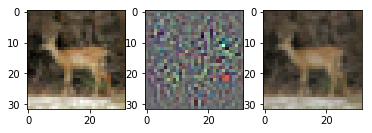



pred: 8
Label: 4


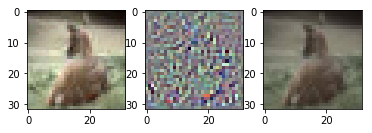



pred: 9
Label: 7


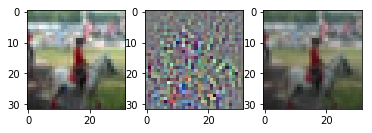



pred: 8
Label: 5


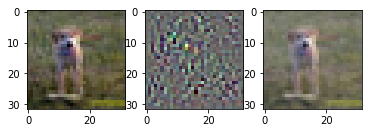



pred: 8
Label: 7


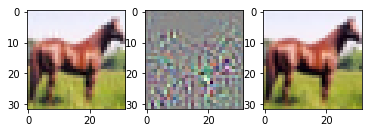



pred: 8
Label: 6


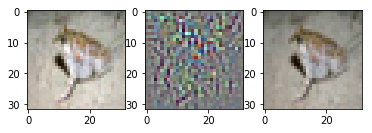



pred: 8
Label: 1


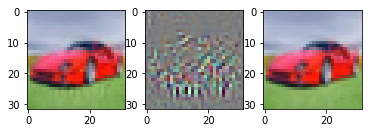



pred: 8
Label: 4


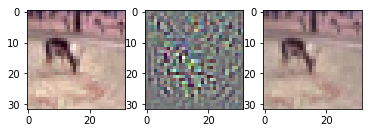



pred: 8
Label: 3


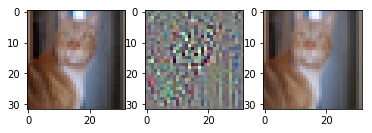



pred: 8
Label: 4


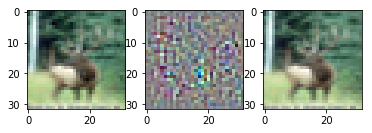



pred: 8
Label: 2


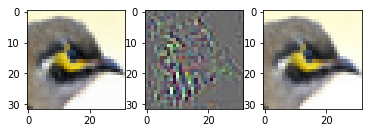



pred: 8
Label: 2


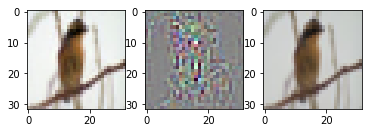



pred: 8
Label: 7


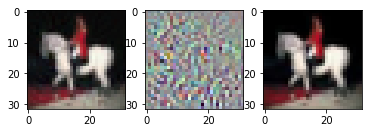



pred: 8
Label: 1


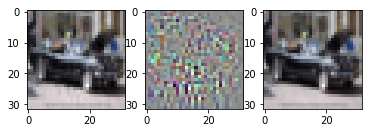



pred: 8
Label: 9


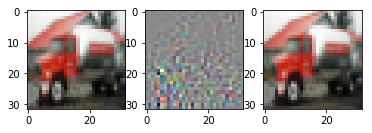



pred: 8
Label: 1


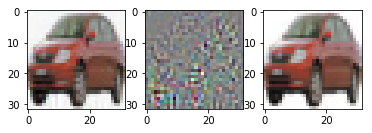



pred: 8
Label: 3


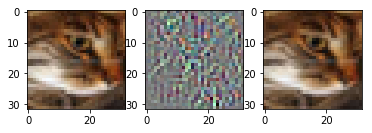



pred: 8
Label: 6


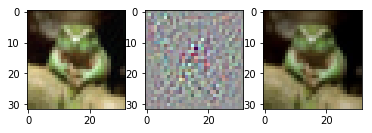



pred: 8
Label: 3


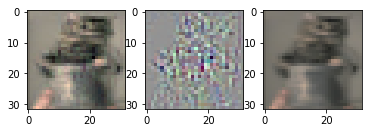



pred: 8
Label: 6


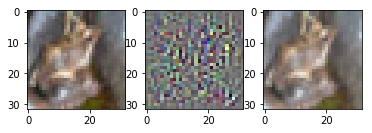



pred: 8
Label: 2


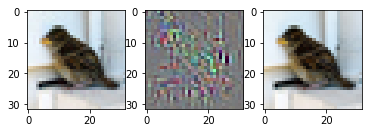



pred: 8
Label: 4


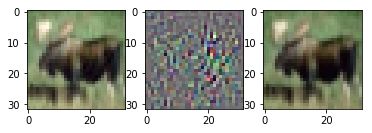



pred: 8
Label: 0


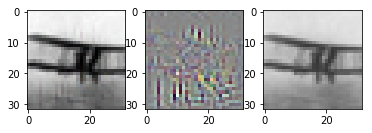



pred: 8
Label: 4


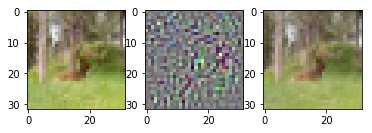



pred: 8
Label: 0


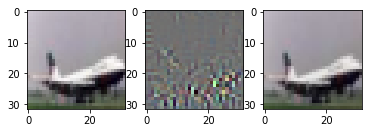



pred: 8
Label: 3


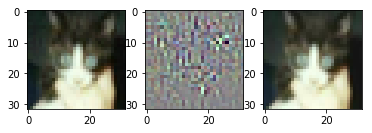



pred: 8
Label: 9


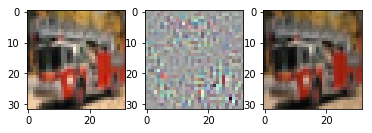



pred: 8
Label: 6


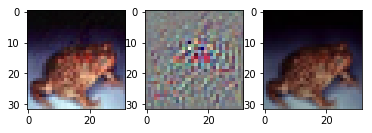



pred: 8
Label: 7


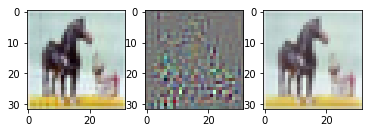



pred: 8
Label: 6


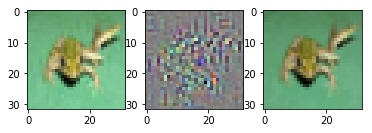



pred: 8
Label: 3


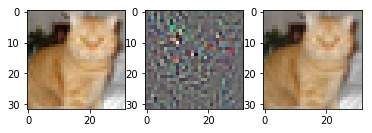



pred: 8
Label: 1


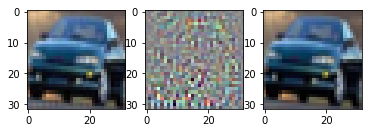



pred: 8
Label: 1


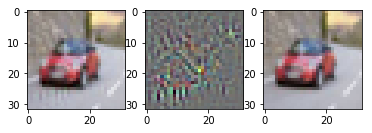

In [178]:
pred = torch.argmax(my_model(test_adv),1)

for i, adv_im in enumerate(test_adv):    
    t = adv_im.clone()
    t = t - t.min()
    t = t/t.max()

    s = test_pert[i].clone()
    s = s - s.min()
    s = s/s.max()

    print('pred: {}'.format(torch.argmax(my_model(t.unsqueeze(0)),1).item()))
    print('Label: {}'.format(orig_label[i]))
    
    plt.subplot(1,3,1)
    plt.imshow(t.squeeze(0).numpy().transpose((1,2,0)))
    plt.subplot(1,3,2)
    plt.imshow(s.squeeze(0).numpy().transpose((1,2,0)))
    plt.subplot(1,3,3)
    plt.imshow(orig_im[i].squeeze(0).numpy().transpose((1,2,0)))
    plt.show()
    
    print('\n')
    

# Generate adversarial images

In [174]:
def fool(images,
         labels,
         model,
         target,
         epsilon=5e-2,
         num_iters=100,
         max_L2_norm=None):
    '''
    Generate adversarial images utilizing the Fast Gradient Sign method
    Arguments:
        - input_imgs: torch tensor of input images
        - model: model used to make predictions
        - target: class to trick the model into predicting
        - epsilon: scalar by which to multiply gradient when perturbing natural input
        - num_iters: maximum number of times to add a perturbation to image
    '''
    start = time.time()
    images = images.clone()
    
    # Subset batch:
    # Only keep images that are correctly classified
    # Only keep images not already belonging to target class
    pred = torch.argmax(model(images), 1)
    mask = (pred == labels) * (labels != target)
    images, labels = images[mask], labels[mask]
    original_images, original_labels = images.clone(), labels.clone()
    
    images.requires_grad_(True)  # very important!
    # We don't need the gradients of anything else
    for param in model.parameters():
        param.requires_grad_(False)
    
    perturbation = torch.zeros_like(images)
    fooled = False
    iteration = 0

    dout = torch.zeros_like(model(images), dtype=torch.float)
    dout[:,target] = 1.  # only compute gradient w.r.t. target class
    
    required_iters = torch.ones_like(labels).type(torch.float)

    while fooled is False and iteration < num_iters:
        
        output = model(images)
        model.zero_grad() # zero out all gradients in model so they don't accumulate
        grad = torch.autograd.grad(outputs=output, inputs=images, grad_outputs=dout)[0]
        
        with torch.no_grad():
            perturbation.add_(epsilon * grad )
            images.add_(epsilon * grad )
                        
            predictions = torch.argmax(model(images), 1)
            
            # If an example is correctly predicted, set all upward gradients
            # flowing to that example to zero; we've successfully found an
            # adversarial image that tricks the model and no longer need to 
            # update the original. We keep looping to try to find successful
            # adversarial images for the other examples.
            dout[:,target] = (predictions != target)
            required_iters.add_( (predictions != target).type(torch.float) )
            
            # If every adversarial example fooled the model, we're done
            if (predictions == target).sum() == labels.size(0):
                fooled = True
            iteration += 1
            
    print('Took {:.2f} seconds'.format(time.time() - start))
    print('Required iterations: \n{}'.format(required_iters))
            
    return (original_images, original_labels, perturbation.detach(), images.detach())

In [ ]:
def make_adv_dataset():
    '''
    Create a dataset of adversarial images
    
    
    take as input what?
    - maybe you should make this a class
    - init loads all data of a certain type (MNIST vs CIFAR)
    - init loads a pretrained model (for either MNIST or CIFAR)
    - make a separate utils.py file that does these two tasks
    
    methods
    - fool() method.
        - Make a class attribute be the generated adversarial set?
        - This will use the attributes of a pretrained model and dataset initialized in init
        - Have options specifying how many adversarial images to generate
    - a testing/calibration method for testing out the parameters that you'll use in fool() method
    - Method to visualize side by side 
    - Method to create an adversarial dataset
        - input should be the filename of where the created dataset will be stored. Save as a pickle?
    - You'll need to write somewhere a function that takes as input the saved pickle and 
        creates a Pytorch dataset/dataloader from it. 
        - This will take as input the path to the pickle
        - Optional input arguments: the original class and the target class. You'll have to do 
            some subsetting/slicing for this. Should be very straightforward
    
    
    '''
    return